Signal Decomposition and motor unit detection

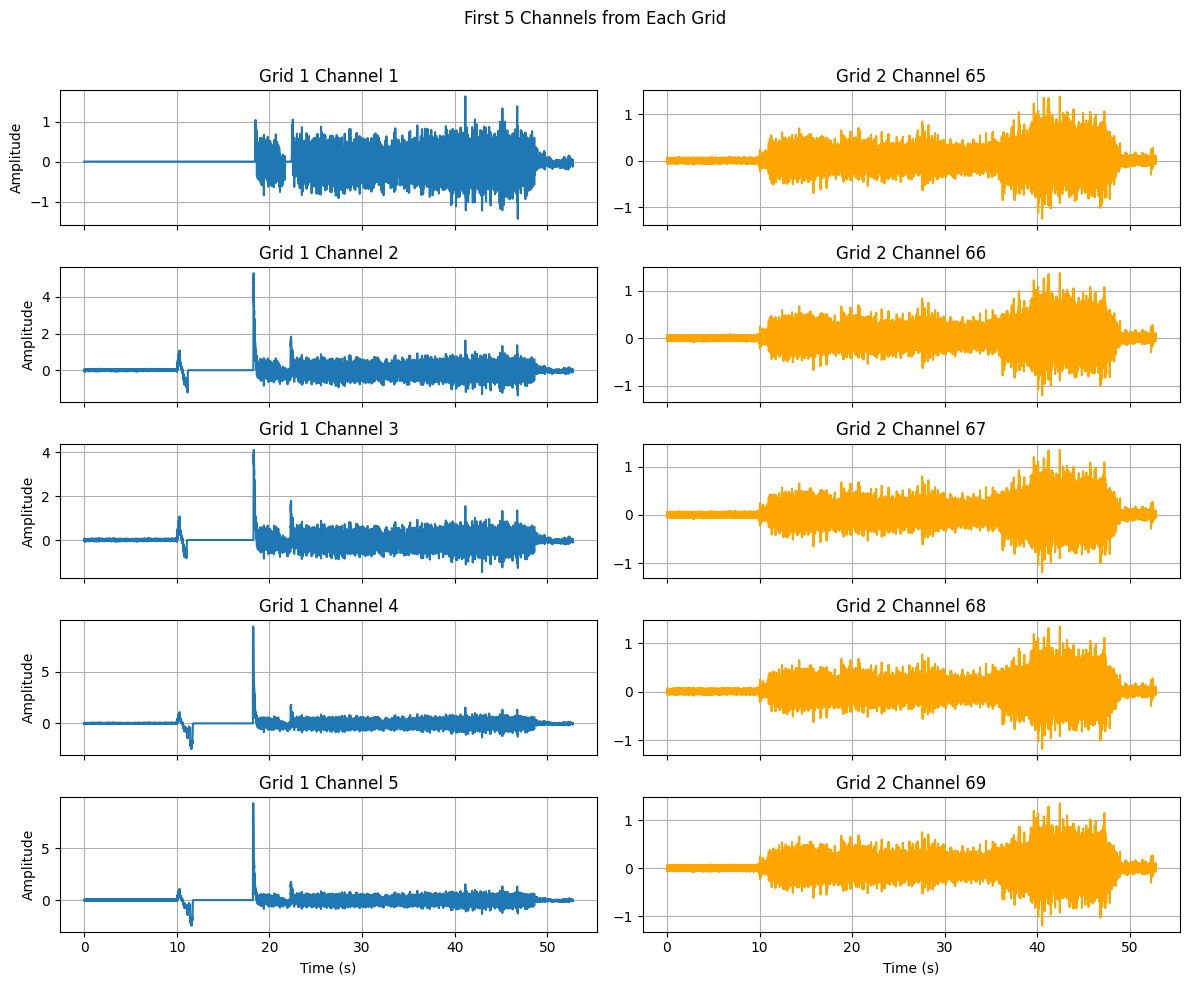

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt

# Load the CSV data using file paths
file_path1 = "C:/Users/schmi/Documents/Studium/TUM/5. Semester/Masterthesis/Experimental Data/Pilot/OTB+/CSV Files/20241001144826_12_Pilot_Grit1.csv"
file_path2 = "C:/Users/schmi/Documents/Studium/TUM/5. Semester/Masterthesis/Experimental Data/Pilot/OTB+/CSV Files/20241001144826_12_Pilot_Grit2.csv"
emg_data_1 = pd.read_csv(file_path1, skiprows=3, sep=';', header=None)
emg_data_2 = pd.read_csv(file_path2, skiprows=3, sep=';', header=None)

# Convert data from comma to point if necessary and ensure it is numeric
emg_data_1 = emg_data_1.apply(lambda col: col.map(lambda x: float(str(x).replace(',', '.')) if isinstance(x, str) else x))
emg_data_2 = emg_data_2.apply(lambda col: col.map(lambda x: float(str(x).replace(',', '.')) if isinstance(x, str) else x))

# Extract time and signals
time_1 = emg_data_1.iloc[:, 0].values  # Time values from the first column of the first grid
signals_1 = emg_data_1.iloc[:, 1:].values  # EMG signals from 64 channels of the first grid

time_2 = emg_data_2.iloc[:, 0].values  # Time values from the first column of the second grid
signals_2 = emg_data_2.iloc[:, 1:].values  # EMG signals from 64 channels of the second grid


min_length = min(len(time_1), len(time_2))
time_1 = time_1[:min_length]
time_2 = time_2[:min_length]
signals_1 = signals_1[:min_length]
signals_2 = signals_2[:min_length]

# Recalculate the time vector based on expected duration and step
time = np.arange(0, min_length * 0.0005, 0.0005)  # 0.0005 is the time step

# Plot the first 5 channels from each grid in separate boxes
num_channels_to_plot = 5
fig, axs = plt.subplots(num_channels_to_plot, 2, figsize=(12, 10), sharex=True)

for i in range(num_channels_to_plot):
    axs[i, 0].plot(time, signals_1[:, i])
    axs[i, 0].set_title(f'Grid 1 Channel {i+1}')
    axs[i, 0].set_ylabel('Amplitude')
    axs[i, 0].grid(True)

    # Adjust index to start from channel 65 for grid 2
    axs[i, 1].plot(time, signals_2[:, i], color='orange')
    axs[i, 1].set_title(f'Grid 2 Channel {i+65}')
    axs[i, 1].grid(True)

for ax in axs[-1, :]:
    ax.set_xlabel('Time (s)')

plt.suptitle('First 5 Channels from Each Grid')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Signal Processing. Normalizing, filtering rectification, Smoothening

combined_smoothed_signals shape = (105497, 128)


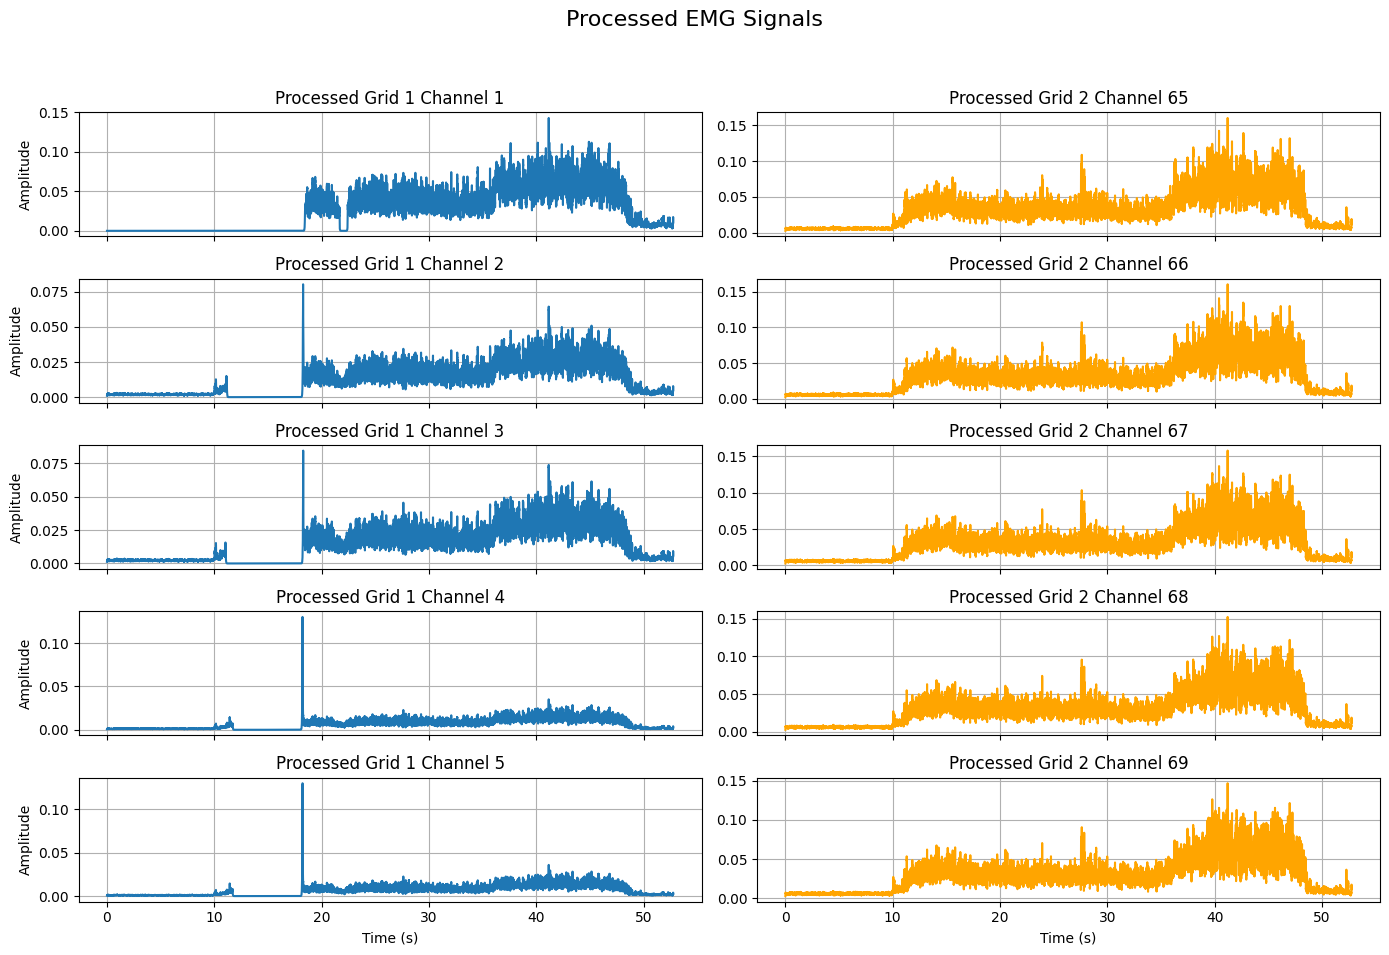

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Normalize the signals with epsilon to prevent division by zero
def normalize_signals(signals):
    signals_min = np.min(signals, axis=0)
    signals_max = np.max(signals, axis=0)
    # Add a small epsilon to avoid division by zero
    epsilon = 1e-10
    return (signals - signals_min) / (signals_max - signals_min + epsilon)

# Handle NaN by replacing with zero or interpolating
def preprocess_nan(signals):
    return np.nan_to_num(signals)

# Preprocess the EMG data (normalize, replace NaNs)
signals_1 = preprocess_nan(signals_1)
signals_2 = preprocess_nan(signals_2)
signals_1 = normalize_signals(signals_1)
signals_2 = normalize_signals(signals_2)

# Define a function to apply a bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data, axis=0)
    return y

# Sampling frequency and filter parameters
fs = 1 / 0.0005  # Based on the time step
lowcut = 20.0  # Lower bound frequency (Hz)
highcut = 450.0  # Upper bound frequency (Hz)

# Apply bandpass filter
filtered_signals_1 = bandpass_filter(signals_1, lowcut, highcut, fs)
filtered_signals_2 = bandpass_filter(signals_2, lowcut, highcut, fs)

# Rectify the signals (take the absolute value)
rectified_signals_1 = np.abs(filtered_signals_1)
rectified_signals_2 = np.abs(filtered_signals_2)

# Smooth the signals using a moving average
def smooth_signals(rectified_signals, window_size=50):
    smoothed_signals = np.zeros_like(rectified_signals)
    for i in range(rectified_signals.shape[1]):
        smoothed_signals[:, i] = np.convolve(rectified_signals[:, i], np.ones(window_size)/window_size, mode='same')
    return smoothed_signals

# Smooth the rectified signals
smoothed_signals_1 = smooth_signals(rectified_signals_1)
smoothed_signals_2 = smooth_signals(rectified_signals_2)

# Concatenate the smoothed signals from both grids
combined_smoothed_signals = np.hstack((smoothed_signals_1, smoothed_signals_2))

# Plotting to inspect the preprocessed signals
print(f"combined_smoothed_signals shape = {combined_smoothed_signals.shape}")

# Define the number of channels to plot
num_channels_to_plot = 5

# Create subplots
fig, axs = plt.subplots(num_channels_to_plot, 2, figsize=(14, 10), sharex=True)
fig.suptitle('Processed EMG Signals', fontsize=16)

for i in range(num_channels_to_plot):
    # Plot for Grid 1 (default color)
    axs[i, 0].plot(time, smoothed_signals_1[:, i])
    axs[i, 0].set_title(f'Processed Grid 1 Channel {i+1}')
    axs[i, 0].set_ylabel('Amplitude')
    axs[i, 0].grid(True)

    # Plot for Grid 2 (orange color)
    axs[i, 1].plot(time, smoothed_signals_2[:, i], color='orange')
    axs[i, 1].set_title(f'Processed Grid 2 Channel {i+65}')
    axs[i, 1].grid(True)

# Set the x-label only on the bottom row
for ax in axs[-1, :]:
    ax.set_xlabel('Time (s)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Motor Unit Decompostion

c:\Users\schmi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


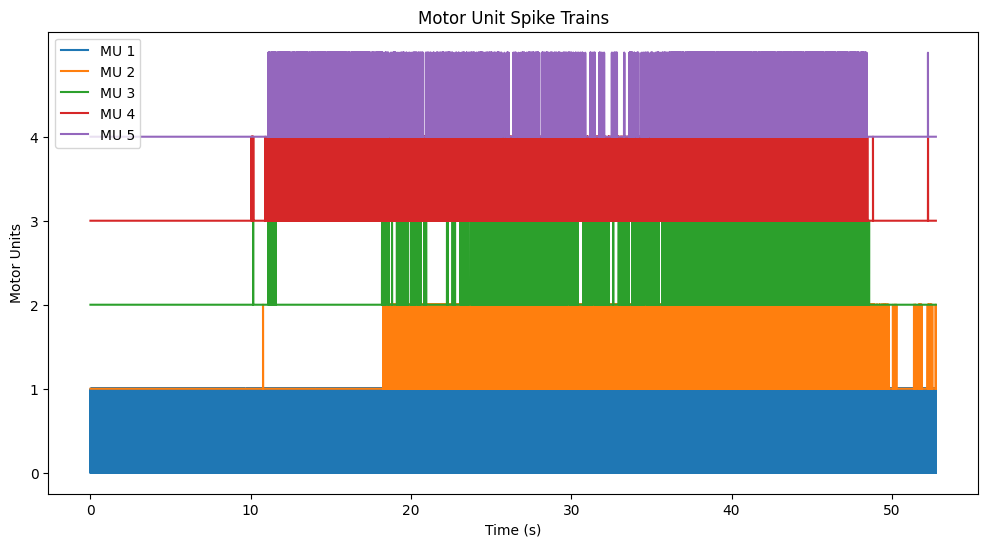

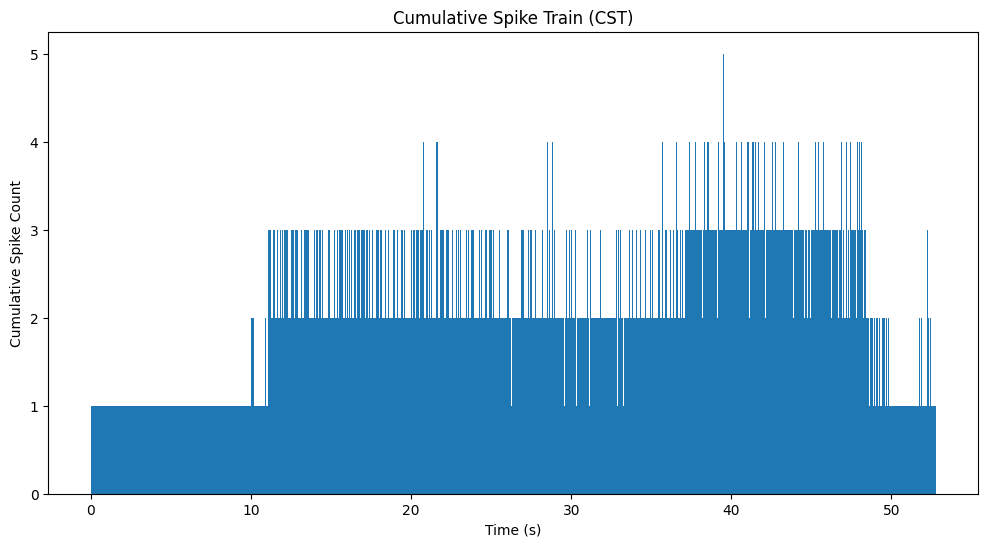

In [4]:

# Extract motor units using a decomposition method
def extract_motor_units(data, n_units=5):
    # Decompose the signal using NMF
    nmf = NMF(n_components=n_units, init='random', random_state=0, max_iter=1000)
    W = nmf.fit_transform(data)
    H = nmf.components_

    # Identify spikes for each motor unit based on activation threshold
    spike_trains = []
    for i in range(n_units):
        peaks, _ = find_peaks(W[:, i], height=0.05)  # Adjust threshold as needed
        spike_train = np.zeros(W.shape[0])
        spike_train[peaks] = 1
        spike_trains.append(spike_train)

    return W, H, spike_trains

W, H, spike_trains = extract_motor_units(combined_smoothed_signals, n_units=5)

# Plot each motor unit spike train
plt.figure(figsize=(12, 6))
for i, spike_train in enumerate(spike_trains):
    plt.plot(time, spike_train + i, label=f'MU {i+1}')
plt.title('Motor Unit Spike Trains')
plt.xlabel('Time (s)')
plt.ylabel('Motor Units')
plt.yticks(np.arange(len(spike_trains)))
plt.legend()
plt.show()

# Plot the cumulative spike train
cumulative_spike_train = np.sum(spike_trains, axis=0)
plt.figure(figsize=(12, 6))
plt.bar(time, cumulative_spike_train, width=0.05)
plt.title('Cumulative Spike Train (CST)')
plt.xlabel('Time (s)')
plt.ylabel('Cumulative Spike Count')
plt.show()

Synergy Extraction 

Shape of EMG data for NMF: (128, 105497)


c:\Users\schmi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


W shape = (128, 4)
H shape = (4, 105497)
W (Synergy Weightings - Contribution of EMG Channels):
[[4.63704257e-03 4.74111962e-01 0.00000000e+00 0.00000000e+00]
 [3.21724126e-03 1.96446557e-01 3.01905519e-04 2.79021165e-02]
 [1.12920555e-03 2.31079121e-01 4.24109221e-03 2.88693770e-02]
 [0.00000000e+00 8.70813449e-02 0.00000000e+00 5.23508512e-02]
 [0.00000000e+00 8.60308106e-02 0.00000000e+00 5.18821450e-02]
 [0.00000000e+00 8.46352857e-02 0.00000000e+00 5.30183998e-02]
 [0.00000000e+00 7.79080316e-02 0.00000000e+00 6.45639950e-02]
 [0.00000000e+00 7.39509723e-02 2.51441928e-03 6.68631583e-02]
 [0.00000000e+00 7.03647355e-02 2.73628983e-03 6.95668175e-02]
 [1.16518040e-03 8.12468792e-02 5.16635846e-04 5.04047840e-02]
 [0.00000000e+00 7.35716789e-02 1.75278493e-03 6.98445507e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.36291062e-01 3.26324574e-03 0.00000000e+00]
 [0.00000000e+00 2.80584984e-01 0.00000000e+00 1.65615415e-02]
 [0.00000000e+00 2.810

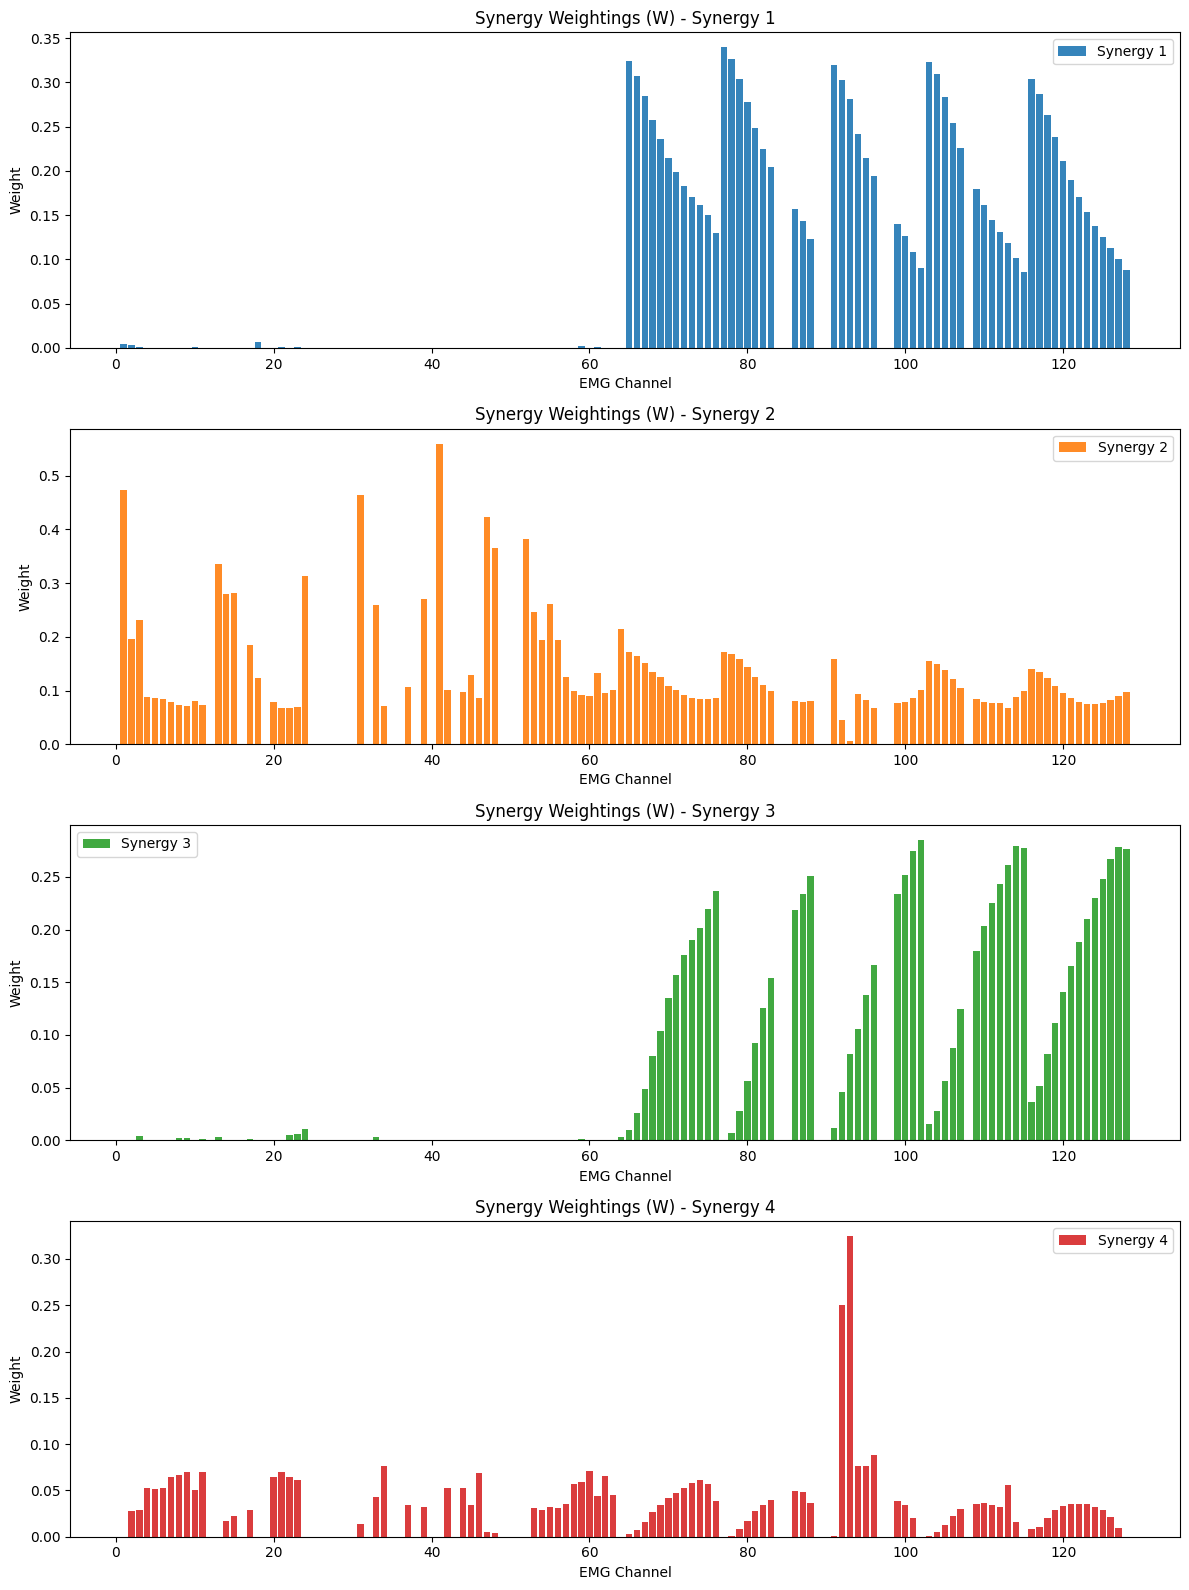

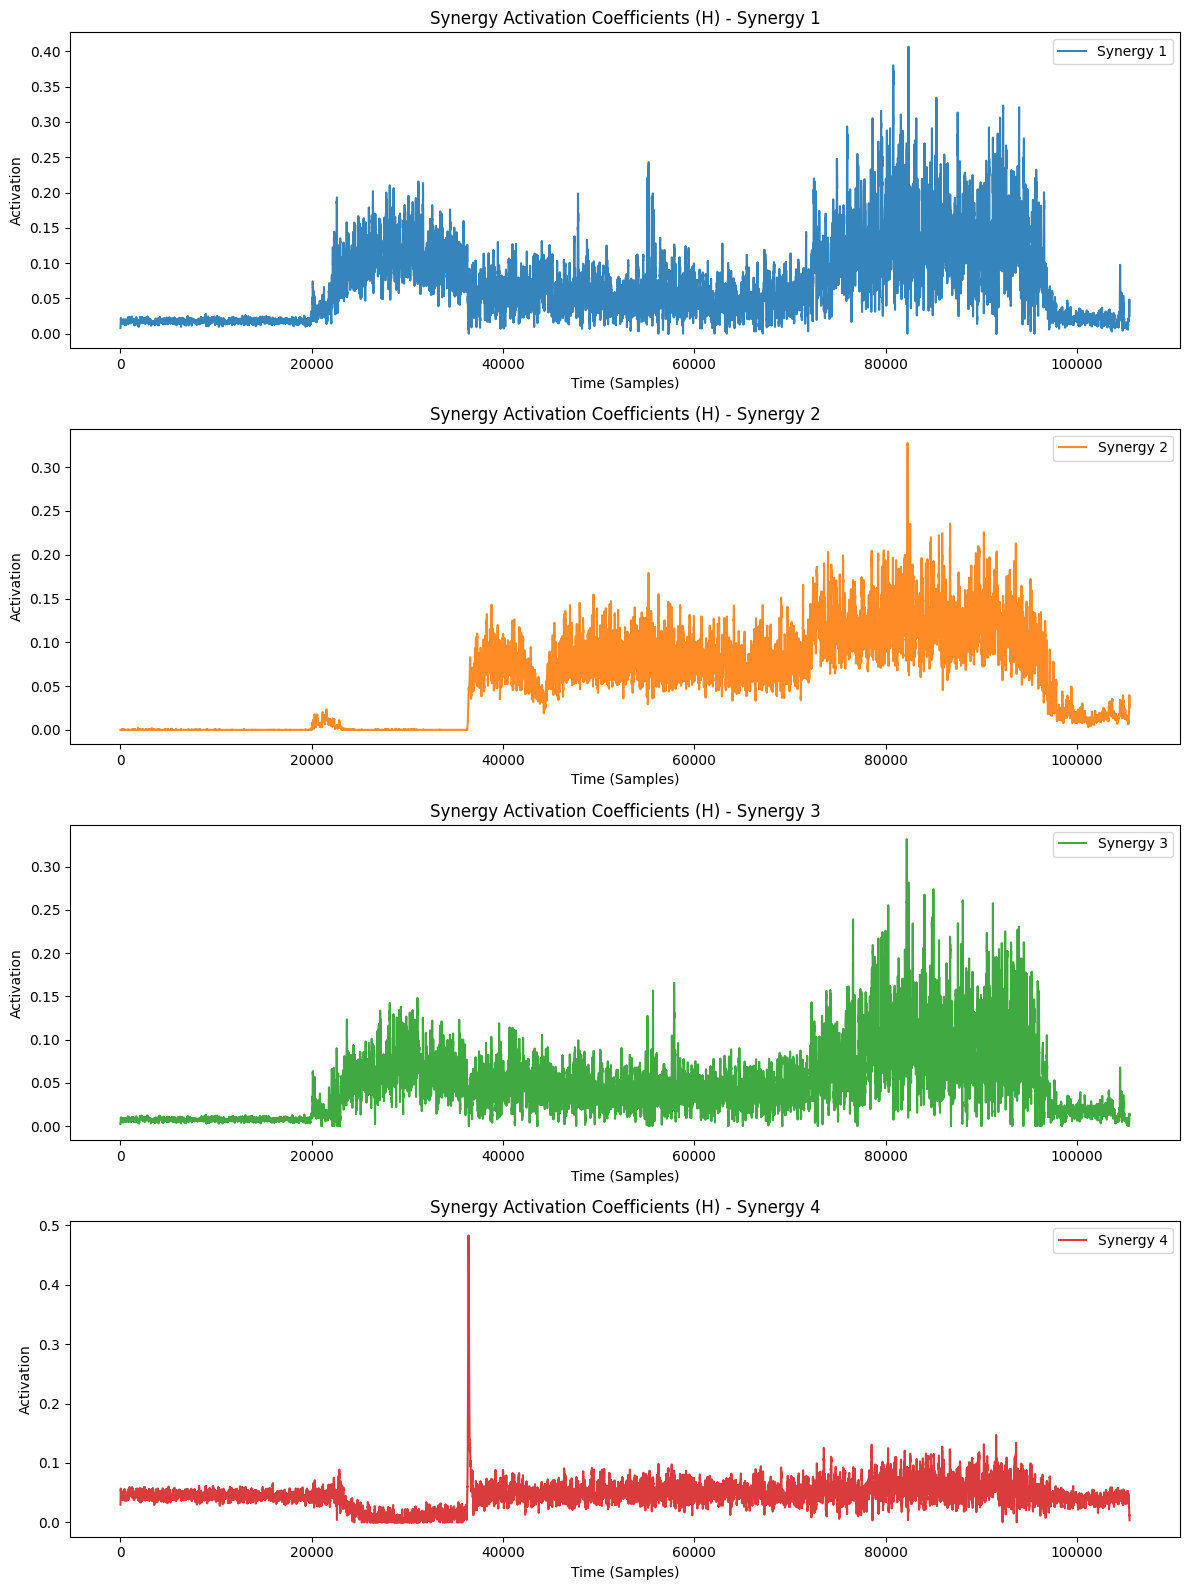

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF

# Assuming combined_smoothed_signals contains only EMG signals
# combined_smoothed_signals should have the shape (n_samples, 128)

# Transpose the EMG data so that it has the shape (128 channels, n_samples)
emg_data = combined_smoothed_signals.T  # Now emg_data has shape (128, n_samples)

# Verify the shape after transpose
print(f"Shape of EMG data for NMF: {emg_data.shape}")

# Extract muscle synergies using NMF
n_synergies = 4  # Number of synergies to extract
model = NMF(n_components=n_synergies, init='random', random_state=0, max_iter=500)
W = model.fit_transform(emg_data)  # Synergy weightings (W) - shape (128, 4)
H = model.components_  # Synergy activation coefficients (H) - shape (4, n_samples)

# Verify the shape of W and H
print(f"W shape = {W.shape}")
print(f"H shape = {H.shape}")

# Results
print("W (Synergy Weightings - Contribution of EMG Channels):")
print(W)
print("\nH (Synergy Activation Coefficients over Time):")
print(H)

# Use the same color scheme as before
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # The colors from the previous plot

# Create subplots for the synergy weightings (W) with a 4x1 layout
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 16))

for i, ax in enumerate(axes):
    ax.bar(np.arange(1, W.shape[0] + 1), W[:, i], color=colors[i], alpha=0.9, label=f'Synergy {i+1}')
    ax.set_title(f'Synergy Weightings (W) - Synergy {i+1}')
    ax.set_xlabel('EMG Channel')
    ax.set_ylabel('Weight')
    ax.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Create subplots for the synergy activation coefficients (H) with a 4x1 layout
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 16))

for i, ax in enumerate(axes):
    ax.plot(np.arange(H.shape[1]), H[i, :], color=colors[i], alpha=0.9, label=f'Synergy {i+1}')
    ax.set_title(f'Synergy Activation Coefficients (H) - Synergy {i+1}')
    ax.set_xlabel('Time (Samples)')
    ax.set_ylabel('Activation')
    ax.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


Reconstruction of the EMG Signal

In [1]:
# Calculate R2 score for different numbers of components in NMF
r2_scores = []
component_range = range(1, 7) 

for n_components in component_range:
    model = NMF(n_components=n_components, init='random', random_state=0, max_iter=500)
    W = model.fit_transform(combined_smoothed_signals)
    H = model.components_
    # Reconstruct the signal
    reconstructed_signal = np.dot(W, H)
    
    # Calculate R2 score
    total_variance = np.sum((combined_smoothed_signals - combined_smoothed_signals.mean(axis=0))**2)
    residual_variance = np.sum((combined_smoothed_signals - reconstructed_signal)**2)
    r2_score = 1 - residual_variance / total_variance
    r2_scores.append(r2_score)

# Plot R2 scores
plt.figure(figsize=(10, 5))
plt.plot(component_range, r2_scores, marker='o')
plt.title('R2 Score for Each Number of Components in NMF')
plt.xlabel('Number of Components')
plt.ylabel('R2 Score')
plt.grid(True)
plt.show()

# Output R2 score for a chosen number of components
print(f"R2 score with {n_synergies} components: {r2_scores[n_synergies-1]:.2f}")

# Plot the original and reconstructed signals for the first channel
channel_to_plot = 65
plt.figure(figsize=(12, 6))
plt.plot(time, combined_smoothed_signals[:, channel_to_plot], label='Original Signal')
plt.plot(time, reconstructed_signal[:, channel_to_plot], linestyle='--', label='Reconstructed Signal')
plt.title(f'Original and Reconstructed EMG Signal with {n_synergies} Components (First Channel)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

NameError: name 'NMF' is not defined

Kinematic Synergies via PCA

              precision    recall  f1-score   support

           1       0.00      1.00      0.00       0.0
           2       1.00      0.00      0.00       1.0
           6       1.00      0.00      0.00       1.0
           7       0.00      1.00      0.00       0.0
           9       0.00      1.00      0.00       0.0
          10       1.00      0.00      0.00       1.0
          16       0.00      1.00      0.00       0.0
          18       1.00      0.00      0.00       1.0
          22       0.00      1.00      0.00       0.0
          24       1.00      0.00      0.00       1.0
          28       0.00      1.00      0.00       0.0
          30       1.00      0.00      0.00       1.0
          31       1.00      0.00      0.00       1.0
          32       0.00      1.00      0.00       0.0
          33       0.00      1.00      0.00       0.0
          39       1.00      0.00      0.00       1.0
          41       1.00      0.00      0.00       1.0
          44       1.00    

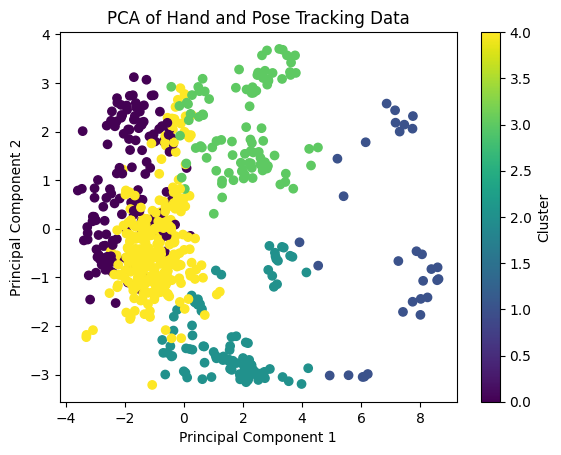

In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Load CSV data
hand_landmarks_file_path = r'c:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Setup\FreeMoCap\recording_sessions\session_2024-08-01_17_30_50\recording_17_38_18_gmt+2\processed_data_17_38_18\hand_landmarks.csv'
pose_landmarks_file_path = r'c:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Setup\FreeMoCap\recording_sessions\session_2024-08-01_17_30_50\recording_17_38_18_gmt+2\processed_data_17_38_18\pose_landmarks.csv'

csv_data = pd.read_csv(hand_landmarks_file_path)

# Load NPY data
hand_npy_file_path = r'c:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Setup\FreeMoCap\recording_sessions\session_2024-08-01_17_30_50\recording_17_38_18_gmt+2\processed_data_17_38_18\hand_landmarks.npy'
pose_npy_file_path = r'c:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Setup\FreeMoCap\recording_sessions\session_2024-08-01_17_30_50\recording_17_38_18_gmt+2\processed_data_17_38_18\pose_landmarks.npy'

hand_npy_data = np.load(hand_npy_file_path)
pose_npy_data = np.load(pose_npy_file_path)

# Ensure both hand and pose data have the same number of frames
num_frames = min(hand_npy_data.shape[0], pose_npy_data.shape[0])
hand_npy_data = hand_npy_data[:num_frames]
pose_npy_data = pose_npy_data[:num_frames]

# Flatten the NPY data to 2D
flattened_hand_data = hand_npy_data.reshape(hand_npy_data.shape[0], -1)
flattened_pose_data = pose_npy_data.reshape(pose_npy_data.shape[0], -1)

# Combine hand and pose data
right_arm_kinematics = np.concatenate((flattened_hand_data, flattened_pose_data), axis=1)

# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(right_arm_kinematics)

# Apply PCA
pca = PCA(n_components=10)
principal_components = pca.fit_transform(normalized_data)

# Prepare labels for classification (if available)
# labels = ...  # Load or define meaningful labels here
labels = np.arange(num_frames)  # Temporary sequential labels for example

# Split the normalized data
X_train, X_test, y_train, y_test = train_test_split(principal_components, labels, test_size=0.2, random_state=42)

# Train the SVM
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# Predict and evaluate
y_pred = svm.predict(X_test)
report = classification_report(y_test, y_pred, zero_division=1)
print(report)

# Apply K-means clustering with explicit n_init
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
clusters = kmeans.fit_predict(principal_components)

# Use only the subset of CSV data that matches the number of frames
csv_data_subset = csv_data.iloc[:num_frames].copy()

# Adding cluster labels to the subset of the original data
csv_data_subset['Cluster'] = clusters

# Save the clustered data to a new CSV file
csv_data_subset.to_csv(r'c:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Setup\FreeMoCap\recording_sessions\session_2024-08-01_17_30_50\recording_17_38_18_gmt+2\processed_data_17_38_18\clustered_data.csv', index=False)

# plot the first two principal components and color by cluster
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Right Arm and Hand Tracking Data')
plt.colorbar(label='Cluster')
plt.show()

In [9]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# File paths for CSV files
hand_landmarks_path = r'c:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Setup\FreeMoCap\recording_sessions\session_2024-08-01_17_30_50\recording_17_38_18_gmt+2\processed_data_17_38_18\hand_landmarks.csv'
pose_landmarks_path = r'c:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Setup\FreeMoCap\recording_sessions\session_2024-08-01_17_30_50\recording_17_38_18_gmt+2\processed_data_17_38_18\pose_landmarks.csv'

# Load CSV files
hand_landmarks_df = pd.read_csv(hand_landmarks_path)
pose_landmarks_df = pd.read_csv(pose_landmarks_path)

# Extract unique frame indices
frame_indices = hand_landmarks_df['frame_index'].unique()

# Define connections for the hand, elbow, and shoulder structure
connections = [
    # Hand connections
    (0, 1), (1, 2), (2, 3), (3, 4),  # Thumb
    (0, 5), (5, 6), (6, 7), (7, 8),  # Index finger
    (9, 10), (10, 11), (11, 12),     # Middle finger
    (13, 14), (14, 15), (15, 16),    # Ring finger
    (0, 17), (17, 18), (18, 19), (19, 20),  # Pinky
    (5, 9), (9, 13), (13, 17),       # Palm connections
    # Elbow and Shoulder connections
    ('shoulder', 'elbow'),
    ('elbow', 'wrist'),
    ('wrist', 0)  # Wrist connected to hand landmark 0 (wrist base)
]

# Function to create frames for animation
def create_frames(hand_data, pose_data, frame_indices):
    frames = []
    for frame in frame_indices:
        # Filter data for the current frame
        hand_frame_data = hand_data[hand_data['frame_index'] == frame]
        pose_frame_data = pose_data[pose_data['frame_index'] == frame]

        if pose_frame_data.empty:
            continue

        traces = []

        # Hand landmarks
        for start, end in connections[:len(connections) - 3]:
            start_coords = hand_frame_data[hand_frame_data['landmark_index'] == start][['x', 'y', 'z']].values
            end_coords = hand_frame_data[hand_frame_data['landmark_index'] == end][['x', 'y', 'z']].values
            if len(start_coords) > 0 and len(end_coords) > 0:
                traces.append(go.Scatter3d(
                    x=[start_coords[0][0], end_coords[0][0]],
                    y=[start_coords[0][1], end_coords[0][1]],
                    z=[start_coords[0][2], end_coords[0][2]],
                    mode='lines+markers',
                    marker=dict(size=5, color='blue'),
                    line=dict(color='darkgrey', width=5)
                ))

        # Pose landmarks (shoulder, elbow, wrist)
        shoulder_coords = pose_frame_data[['shoulder_x', 'shoulder_y', 'shoulder_z']].values[0]
        elbow_coords = pose_frame_data[['elbow_x', 'elbow_y', 'elbow_z']].values[0]
        wrist_coords = pose_frame_data[['wrist_x', 'wrist_y', 'wrist_z']].values[0]

        # Shoulder to elbow
        traces.append(go.Scatter3d(
            x=[shoulder_coords[0], elbow_coords[0]],
            y=[shoulder_coords[1], elbow_coords[1]],
            z=[shoulder_coords[2], elbow_coords[2]],
            mode='lines+markers',
            marker=dict(size=8, color='red'),
            line=dict(color='darkgrey', width=8)
        ))

        # Elbow to wrist
        traces.append(go.Scatter3d(
            x=[elbow_coords[0], wrist_coords[0]],
            y=[elbow_coords[1], wrist_coords[1]],
            z=[elbow_coords[2], wrist_coords[2]],
            mode='lines+markers',
            marker=dict(size=8, color='green'),
            line=dict(color='darkgrey', width=8)
        ))

        frames.append(go.Frame(data=traces))
    return frames

# Create initial plot
initial_data = []
initial_frame_data = hand_landmarks_df[hand_landmarks_df['frame_index'] == frame_indices[0]]
pose_frame_data = pose_landmarks_df[pose_landmarks_df['frame_index'] == frame_indices[0]]

if not pose_frame_data.empty:
    # Hand landmarks (initial)
    for start, end in connections[:len(connections) - 3]:
        start_coords = initial_frame_data[initial_frame_data['landmark_index'] == start][['x', 'y', 'z']].values
        end_coords = initial_frame_data[initial_frame_data['landmark_index'] == end][['x', 'y', 'z']].values
        if len(start_coords) > 0 and len(end_coords) > 0:
            initial_data.append(go.Scatter3d(
                x=[start_coords[0][0], end_coords[0][0]],
                y=[start_coords[0][1], end_coords[0][1]],
                z=[start_coords[0][2], end_coords[0][2]],
                mode='lines+markers',
                marker=dict(size=5, color='blue'),
                line=dict(color='darkgrey', width=5)
            ))

    # Pose landmarks (initial)
    shoulder_coords = pose_frame_data[['shoulder_x', 'shoulder_y', 'shoulder_z']].values[0]
    elbow_coords = pose_frame_data[['elbow_x', 'elbow_y', 'elbow_z']].values[0]
    wrist_coords = pose_frame_data[['wrist_x', 'wrist_y', 'wrist_z']].values[0]

    # Shoulder to elbow
    initial_data.append(go.Scatter3d(
        x=[shoulder_coords[0], elbow_coords[0]],
        y=[shoulder_coords[1], elbow_coords[1]],
        z=[shoulder_coords[2], elbow_coords[2]],
        mode='lines+markers',
        marker=dict(size=8, color='red'),
        line=dict(color='darkgrey', width=8)
    ))

    # Elbow to wrist
    initial_data.append(go.Scatter3d(
        x=[elbow_coords[0], wrist_coords[0]],
        y=[elbow_coords[1], wrist_coords[1]],
        z=[elbow_coords[2], wrist_coords[2]],
        mode='lines+markers',
        marker=dict(size=8, color='green'),
        line=dict(color='darkgrey', width=8)
    ))

# Create figure
fig = go.Figure(
    data=initial_data,
    layout=go.Layout(
        title="3D Hand, Elbow, and Shoulder Landmarks Animation",
        scene=dict(
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z')
        ),
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None, {"frame": {"duration": 100, "redraw": True}, "fromcurrent": True}]),
                     dict(label="Pause",
                          method="animate",
                          args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate", "transition": {"duration": 0}}])]
        )]
    ),
    frames=create_frames(hand_landmarks_df, pose_landmarks_df, frame_indices)
)

# Save the figure as an HTML file
output_html_path = "hand_elbow_shoulder_animation.html"
fig.write_html(output_html_path)
print(f"Animation saved as {output_html_path}")

# Optionally show the figure
fig.show()

Animation saved as hand_elbow_shoulder_animation.html


Kinematic Variables

In [24]:
import pandas as pd

# List of kinematic variables
kinematic_variables = [
    "right_hand_wrist_x", "right_hand_wrist_y", "right_hand_wrist_z",
    "right_hand_thumb_cmc_x", "right_hand_thumb_cmc_y", "right_hand_thumb_cmc_z",
    "right_hand_thumb_mcp_x", "right_hand_thumb_mcp_y", "right_hand_thumb_mcp_z",
    "right_hand_thumb_ip_x", "right_hand_thumb_ip_y", "right_hand_thumb_ip_z",
    "right_hand_thumb_tip_x", "right_hand_thumb_tip_y", "right_hand_thumb_tip_z",
    "right_hand_index_finger_mcp_x", "right_hand_index_finger_mcp_y", "right_hand_index_finger_mcp_z",
    "right_hand_index_finger_pip_x", "right_hand_index_finger_pip_y", "right_hand_index_finger_pip_z",
    "right_hand_index_finger_dip_x", "right_hand_index_finger_dip_y", "right_hand_index_finger_dip_z",
    "right_hand_index_finger_tip_x", "right_hand_index_finger_tip_y", "right_hand_index_finger_tip_z",
    "right_hand_middle_finger_mcp_x", "right_hand_middle_finger_mcp_y", "right_hand_middle_finger_mcp_z",
    "right_hand_middle_finger_pip_x", "right_hand_middle_finger_pip_y", "right_hand_middle_finger_pip_z",
    "right_hand_middle_finger_dip_x", "right_hand_middle_finger_dip_y", "right_hand_middle_finger_dip_z",
    "right_hand_middle_finger_tip_x", "right_hand_middle_finger_tip_y", "right_hand_middle_finger_tip_z",
    "right_hand_ring_finger_mcp_x", "right_hand_ring_finger_mcp_y", "right_hand_ring_finger_mcp_z",
    "right_hand_ring_finger_pip_x", "right_hand_ring_finger_pip_y", "right_hand_ring_finger_pip_z",
    "right_hand_ring_finger_dip_x", "right_hand_ring_finger_dip_y", "right_hand_ring_finger_dip_z",
    "right_hand_ring_finger_tip_x", "right_hand_ring_finger_tip_y", "right_hand_ring_finger_tip_z",
    "right_hand_pinky_mcp_x", "right_hand_pinky_mcp_y", "right_hand_pinky_mcp_z",
    "right_hand_pinky_pip_x", "right_hand_pinky_pip_y", "right_hand_pinky_pip_z",
    "right_hand_pinky_dip_x", "right_hand_pinky_dip_y", "right_hand_pinky_dip_z",
    "right_hand_pinky_tip_x", "right_hand_pinky_tip_y", "right_hand_pinky_tip_z"
]

# Create the mapping of variable number to kinematic variable
kinematic_var_map = {i+128: kinematic_variables[i] for i in range(len(kinematic_variables))}

# Convert the mapping to a DataFrame for visualization
kinematic_var_df = pd.DataFrame(list(kinematic_var_map.items()), columns=["Variable Number", "Kinematic Variable"])

# Display the DataFrame
print(kinematic_var_df)


    Variable Number      Kinematic Variable
0               128      right_hand_wrist_x
1               129      right_hand_wrist_y
2               130      right_hand_wrist_z
3               131  right_hand_thumb_cmc_x
4               132  right_hand_thumb_cmc_y
..              ...                     ...
58              186  right_hand_pinky_dip_y
59              187  right_hand_pinky_dip_z
60              188  right_hand_pinky_tip_x
61              189  right_hand_pinky_tip_y
62              190  right_hand_pinky_tip_z

[63 rows x 2 columns]


Signal Synchronization

Shape of Combined Data Matrix (Variables x Samples): (190, 24667)


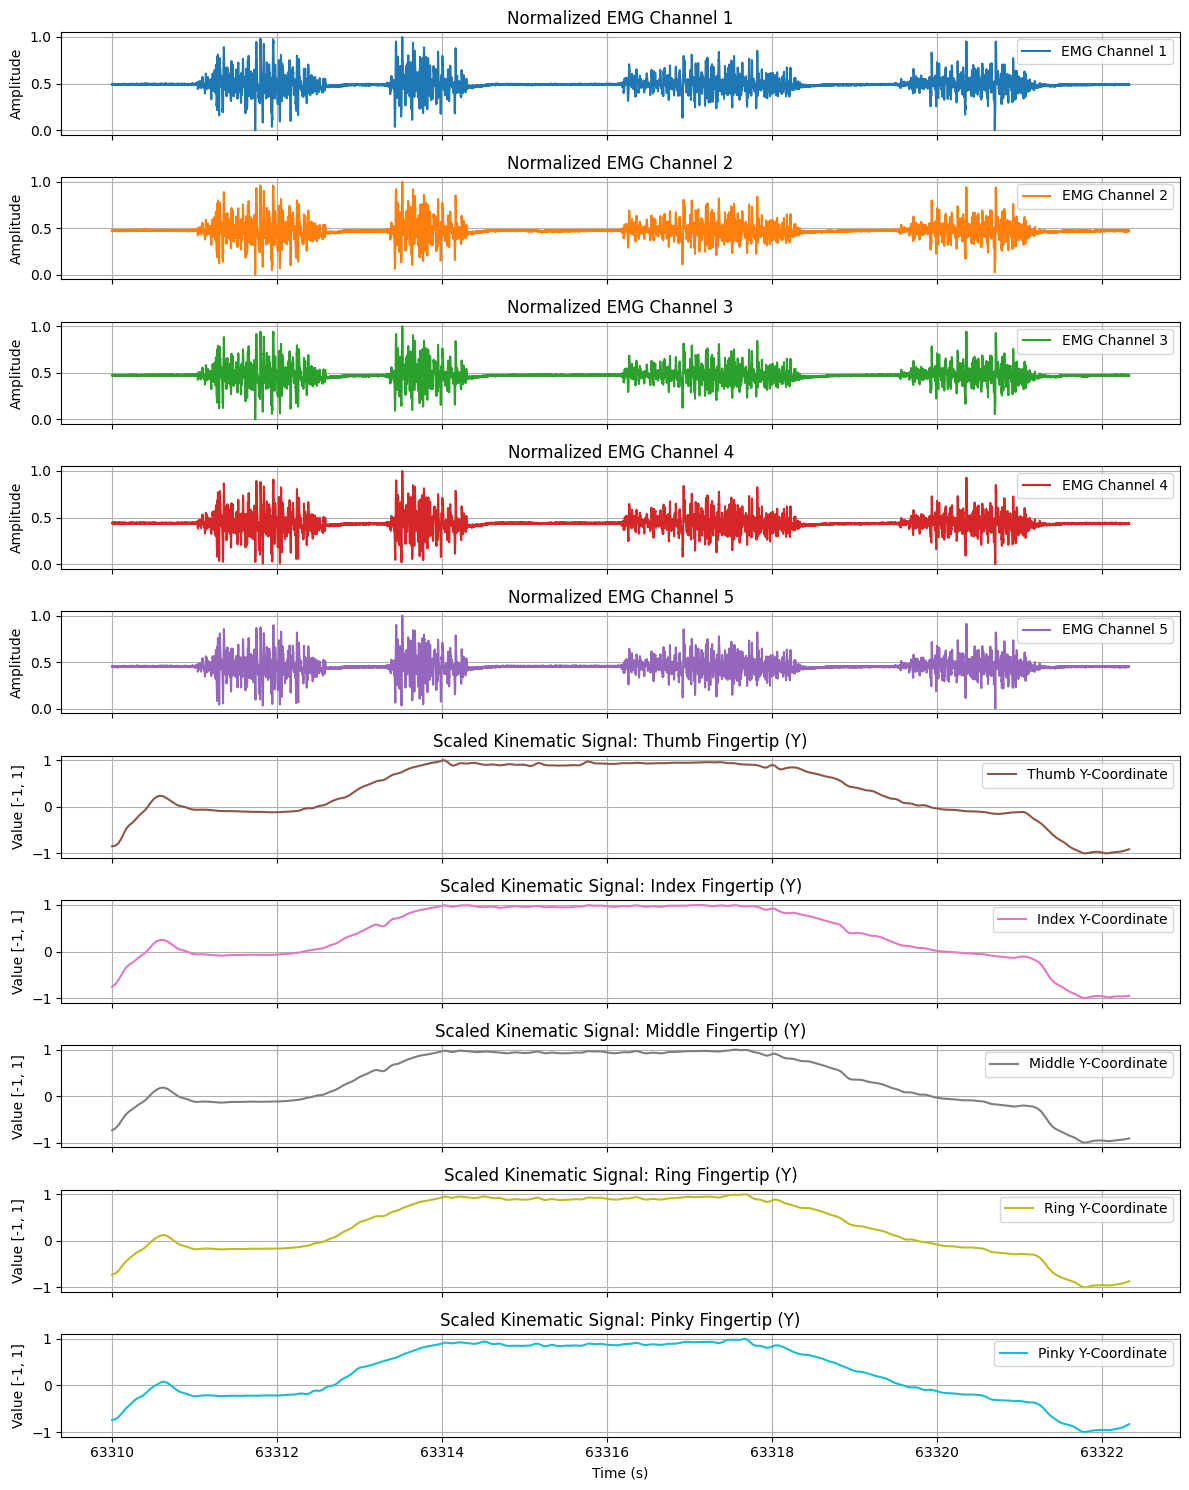

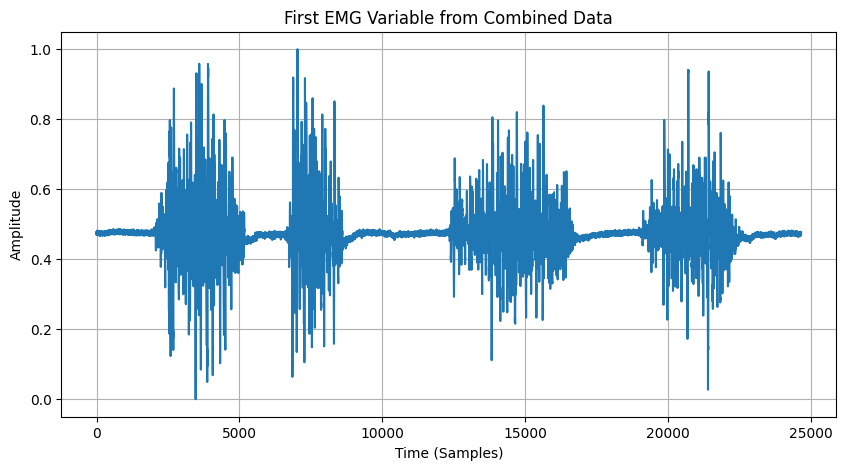

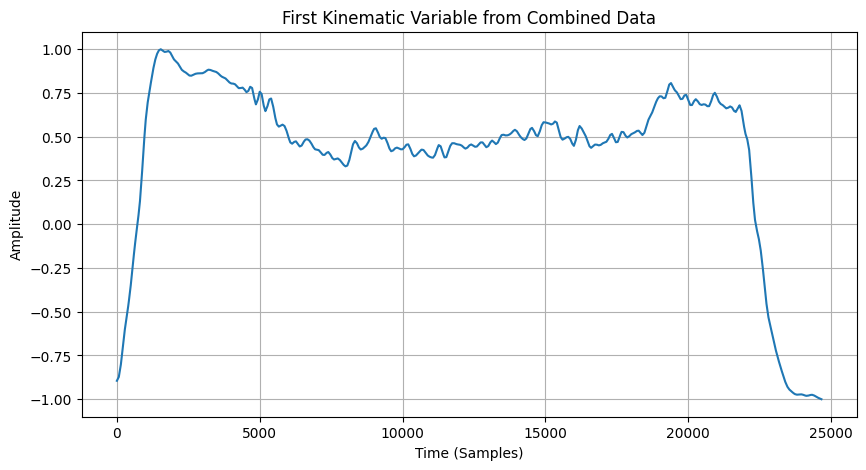

In [2]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Extract start time from filenames
def extract_start_time(filename, is_emg=False):
    if is_emg:
        time_str = filename.split('_')[0][-6:]  # Extract "173454" for EMG data
    else:
        time_str = filename.split('_')[1:4]  # Extract "17", "35", "02" for Kinematic data
        time_str = ''.join(time_str)  # Combine to "173502"

    # Convert hours, minutes, and seconds to total seconds
    hours = int(time_str[:2])
    minutes = int(time_str[2:4])
    seconds = int(time_str[4:6])
    total_seconds = hours * 3600 + minutes * 60 + seconds
    return total_seconds

# File names
kinematic_filename = "recording_17_35_10_gmt+2"
emg_filename = "20240801173454_EMGLudgerGrit128.csv"

# Extract start times
kinematic_start_time = extract_start_time(kinematic_filename)
emg_start_time = extract_start_time(emg_filename, is_emg=True)

# Load kinematic data
kinematic_data_path =  r'C:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Setup\FreeMoCap\recording_sessions\session_2024-07-25_15_59_18\recording_16_06_30_gmt+2\output_data\mediapipe_right_hand_3d_xyz.csv'
emg_data_path = r'C:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Setup\OTB+\20240801173454_EMGLudgerGrit128.csv'
kinematic_data = pd.read_csv(kinematic_data_path)

emg_data = pd.read_csv(emg_data_path, skiprows=3, sep=';', header=None)

# Define sample rates and durations
kinematic_sample_rate = 30  # 30 Hz for kinematic data
emg_sample_rate = 2000  # 2000 Hz for EMG data

kinematic_duration = len(kinematic_data) / kinematic_sample_rate
emg_duration = len(emg_data) / emg_sample_rate

# Create time vectors for both signals
kinematic_time_vector = np.arange(kinematic_start_time, kinematic_start_time + kinematic_duration, 1 / kinematic_sample_rate)
emg_time_vector = np.arange(emg_start_time, emg_start_time + emg_duration, 1 / emg_sample_rate)

# Find overlapping time interval between the signals
start_time = max(emg_time_vector[0], kinematic_time_vector[0])
end_time = min(emg_time_vector[-1], kinematic_time_vector[-1])

# Create overlapping time vectors
trimmed_kinematic_time = np.arange(start_time, end_time, 1 / kinematic_sample_rate)
trimmed_emg_time = np.arange(start_time, end_time, 1 / emg_sample_rate)

# Trim the kinematic and EMG signals
kinematic_start_index = np.searchsorted(kinematic_time_vector, start_time)
kinematic_end_index = np.searchsorted(kinematic_time_vector, end_time)
emg_start_index = np.searchsorted(emg_time_vector, start_time)
emg_end_index = np.searchsorted(emg_time_vector, end_time)

# Slice the signals based on the indices
trimmed_kinematic_signals = kinematic_data.iloc[kinematic_start_index:kinematic_end_index, 1:].to_numpy()
trimmed_emg_signals = emg_data.iloc[emg_start_index:emg_end_index, 1:].to_numpy()

# Interpolate kinematic signals to match EMG sample rate
interpolated_kinematic_signals = np.zeros((len(trimmed_emg_time), trimmed_kinematic_signals.shape[1]))

for i in range(trimmed_kinematic_signals.shape[1]):
    interpolation_function = interp1d(trimmed_kinematic_time, trimmed_kinematic_signals[:, i], kind='linear', fill_value="extrapolate")
    interpolated_kinematic_signals[:, i] = interpolation_function(trimmed_emg_time)

# Normalize EMG signals to [0, 1]
def min_max_normalize(data):
    data_min = np.min(data, axis=0)
    data_max = np.max(data, axis=0)
    return (data - data_min) / (data_max - data_min + 1e-9)

normalized_emg_signals = min_max_normalize(trimmed_emg_signals)

# Normalize kinematic signals to [-1, 1]
def min_max_scale_to_neg1_pos1(data):
    data_min = np.min(data, axis=0)
    data_max = np.max(data, axis=0)
    return 2 * (data - data_min) / (data_max - data_min + 1e-9) - 1

scaled_kinematic_signals = min_max_scale_to_neg1_pos1(interpolated_kinematic_signals)

# Combine EMG and Kinematic data in (variables x samples) format
combined_data = np.vstack((normalized_emg_signals.T, scaled_kinematic_signals.T))

# Print combined data shape
print(f"Shape of Combined Data Matrix (Variables x Samples): {combined_data.shape}")

# Plot combined data: 5 EMG channels + 5 Kinematic (Y coordinates) channels
num_kinematic_signals = 5  # Number of kinematic signals
num_emg_signals = 5  # Number of EMG channels to plot

# Create subplots for EMG and kinematic signals
fig, axes = plt.subplots(num_kinematic_signals + num_emg_signals, 1, figsize=(12, 15), sharex=True)

# Set colors for EMG and kinematic signals
colors = plt.get_cmap('tab10').colors

# Plot the first 5 normalized EMG signals
for i in range(num_emg_signals):
    axes[i].plot(trimmed_emg_time, normalized_emg_signals[:, i], color=colors[i], label=f'EMG Channel {i+1}')
    axes[i].set_title(f'Normalized EMG Channel {i+1}')
    axes[i].set_ylabel('Amplitude')
    axes[i].legend(loc='upper right')
    axes[i].grid(True)

# Select Y-coordinate indices for the fingertips
kinematic_signal_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
y_coordinate_indices = [4, 16, 28, 40, 52]

# Plot the kinematic Y-coordinate signals
for i in range(num_kinematic_signals):
    axes[i + num_emg_signals].plot(trimmed_emg_time, scaled_kinematic_signals[:, y_coordinate_indices[i]], color=colors[i + num_emg_signals],
                                   label=f'{kinematic_signal_names[i]} Y-Coordinate')
    axes[i + num_emg_signals].set_title(f'Scaled Kinematic Signal: {kinematic_signal_names[i]} Fingertip (Y)')
    axes[i + num_emg_signals].set_ylabel('Value [-1, 1]')
    axes[i + num_emg_signals].legend(loc='upper right')
    axes[i + num_emg_signals].grid(True)

# Set common x-label for time
axes[-1].set_xlabel('Time (s)')

# Adjust layout and display
plt.tight_layout()
plt.show()

# Plot the first variable over all samples (corrected version)
plt.figure(figsize=(10, 5))
plt.plot(combined_data[1, :])  # First variable over time (samples)
plt.title('First EMG Variable from Combined Data')
plt.xlabel('Time (Samples)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Plot the first variable over all samples (corrected version)
plt.figure(figsize=(10, 5))
plt.plot(combined_data[128, :])  # First variable over time (samples)
plt.title('First Kinematic Variable from Combined Data')
plt.xlabel('Time (Samples)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

Shape of Combined Data Matrix (Variables x Samples): (190, 24667)
Shape of W (Variables x Synergies): (190, 8)
Shape of C (Synergies x Samples): (8, 24667)
Number of EMG Channels = 128
Iteration 0, Cost: 647204.8769238221
W matrix (first few values): [0.01076969 0.0147411  0.00530173 0.00589772 0.00944645]
C matrix (first few values): [0.0065155  0.00882909 0.00557826 0.00743486 0.00772443]


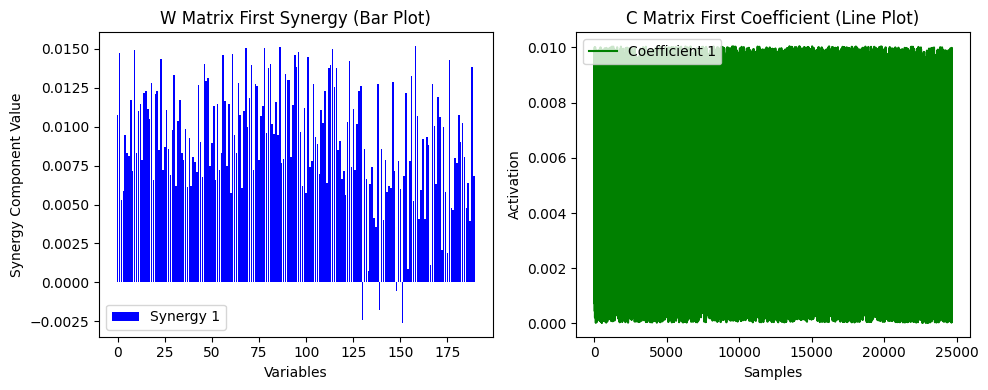

Iteration 100, Cost: 166708.93836046482
W matrix (first few values): [0.68789532 0.67002098 0.65846973 0.61219885 0.63636664]
C matrix (first few values): [0.02712451 0.03025298 0.02414811 0.02651669 0.02741027]


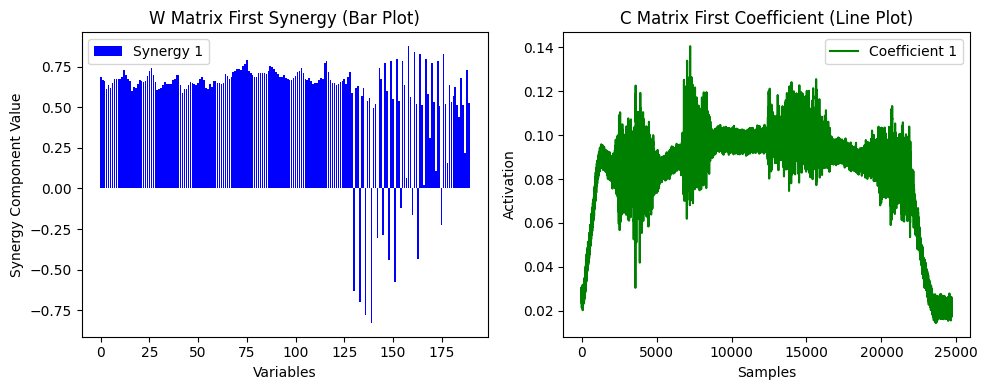

Iteration 200, Cost: 155659.37454569738
W matrix (first few values): [0.6956179  0.67727904 0.66575566 0.61862819 0.64317708]
C matrix (first few values): [0.03010644 0.03326676 0.02700959 0.0294176  0.03034433]


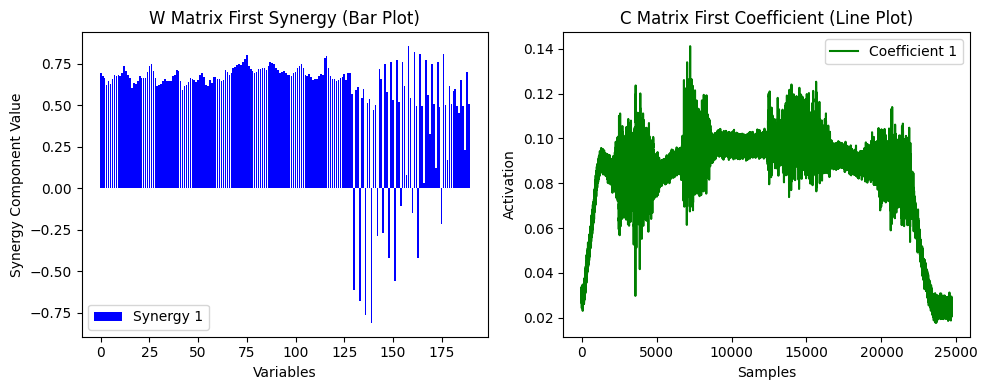

Iteration 300, Cost: 55238.053744031946
W matrix (first few values): [0.7268878  0.70704837 0.69601242 0.64657172 0.67246744]
C matrix (first few values): [0.04322281 0.04634142 0.04018435 0.04275055 0.04376494]


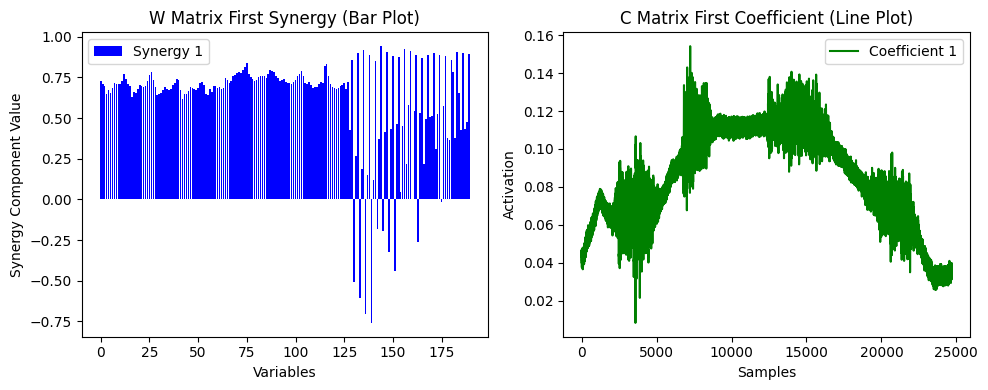

Iteration 400, Cost: 15803.154317595174
W matrix (first few values): [0.78015638 0.7557091  0.74814254 0.69532927 0.72468639]
C matrix (first few values): [0.09392175 0.09710307 0.09162137 0.0952755  0.09571895]


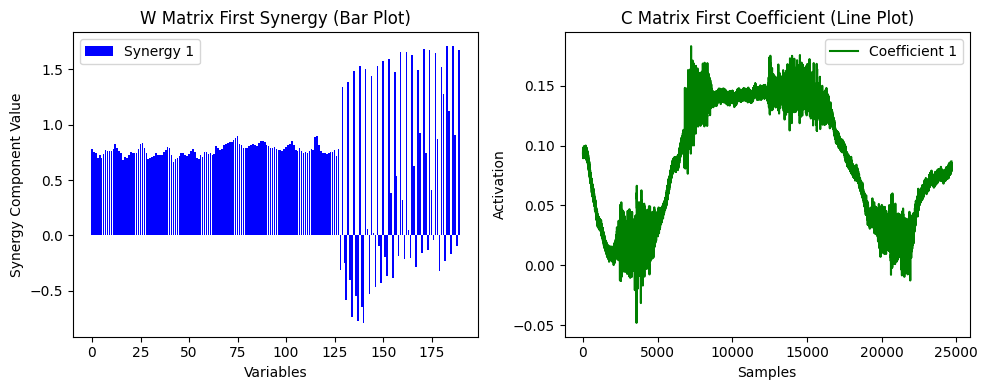

Iteration 500, Cost: 15217.692165299659
W matrix (first few values): [0.79377062 0.76886835 0.76159765 0.70838285 0.73809432]
C matrix (first few values): [0.09257094 0.09575886 0.09043387 0.09446919 0.09469909]


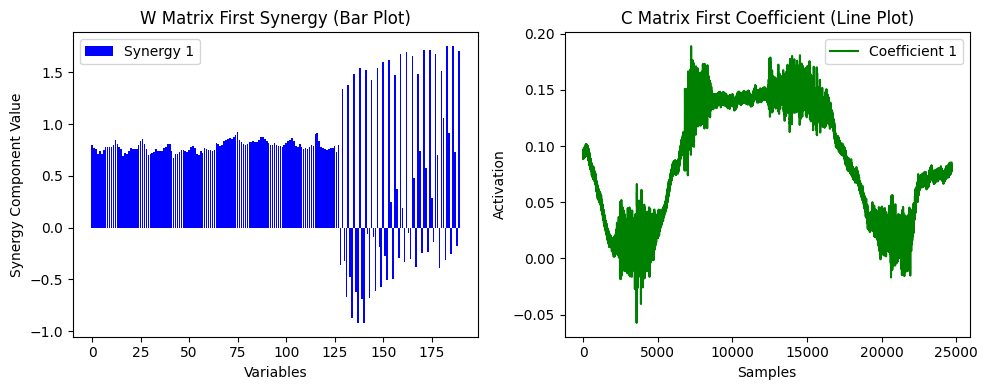

Iteration 600, Cost: 12561.566524438487
W matrix (first few values): [0.82465508 0.79969757 0.79194131 0.73823275 0.76757244]
C matrix (first few values): [0.08529688 0.08843063 0.08290445 0.08712287 0.0870805 ]


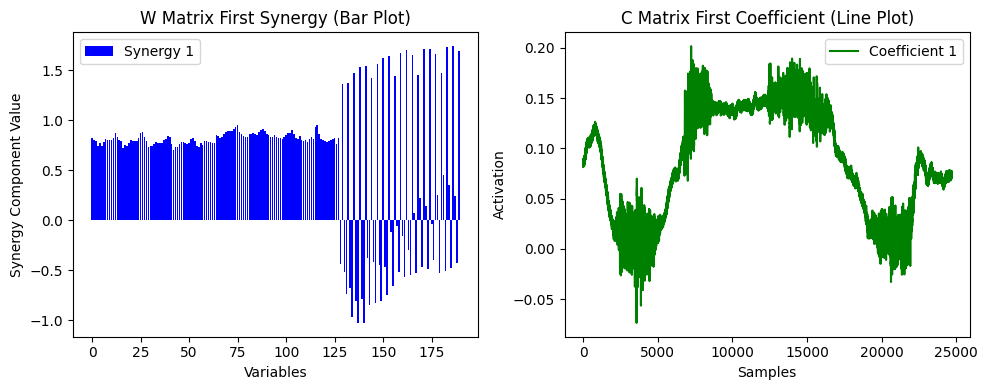

Iteration 700, Cost: 8032.030519926909
W matrix (first few values): [0.8837762  0.85913467 0.85180633 0.79897316 0.8261096 ]
C matrix (first few values): [0.07733378 0.07997997 0.07407245 0.0788629  0.07767755]


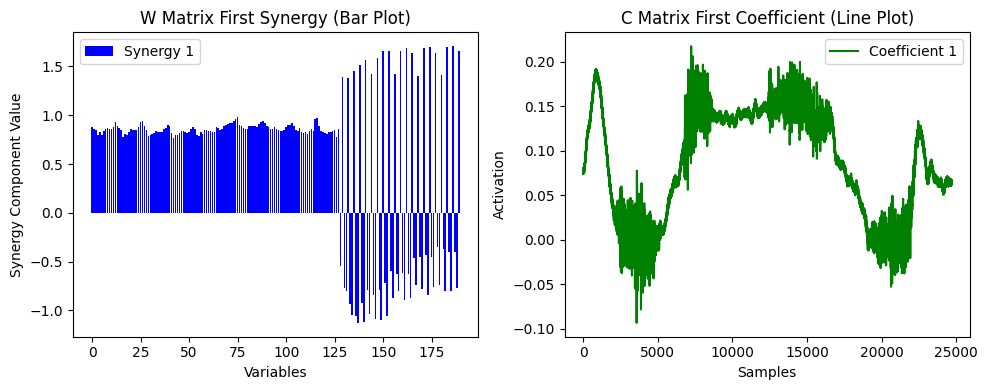

Iteration 800, Cost: 6769.013765576759
W matrix (first few values): [0.95097723 0.92862295 0.92265745 0.87543471 0.89829536]
C matrix (first few values): [0.07759548 0.07954764 0.07364602 0.07890412 0.07650443]


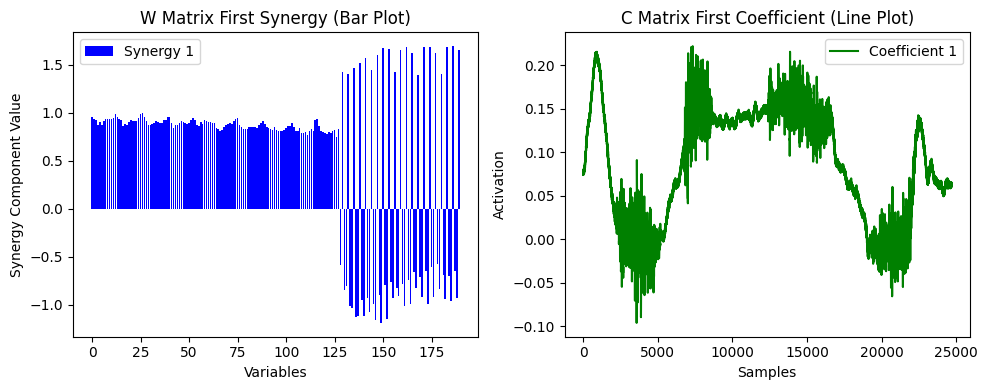

Iteration 900, Cost: 5141.522219196444
W matrix (first few values): [1.03465946 1.01362617 1.00812833 0.96397253 0.98417139]
C matrix (first few values): [0.08211974 0.08350257 0.07817169 0.08339448 0.08042801]


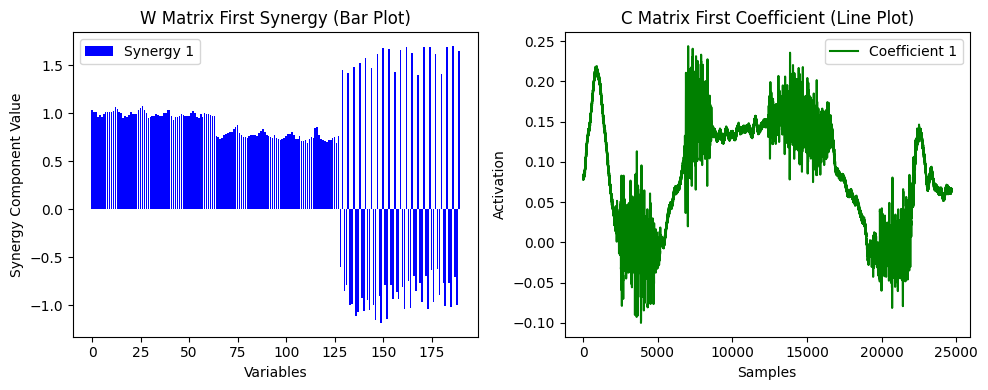

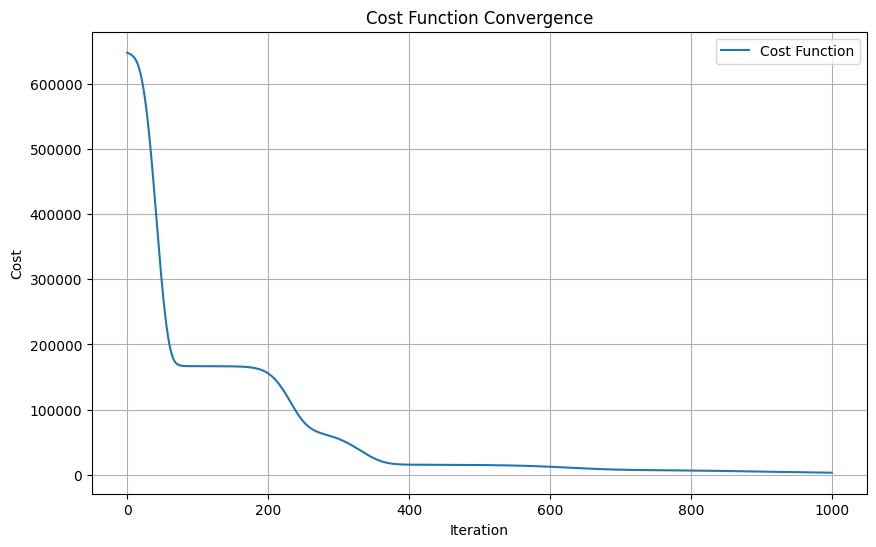

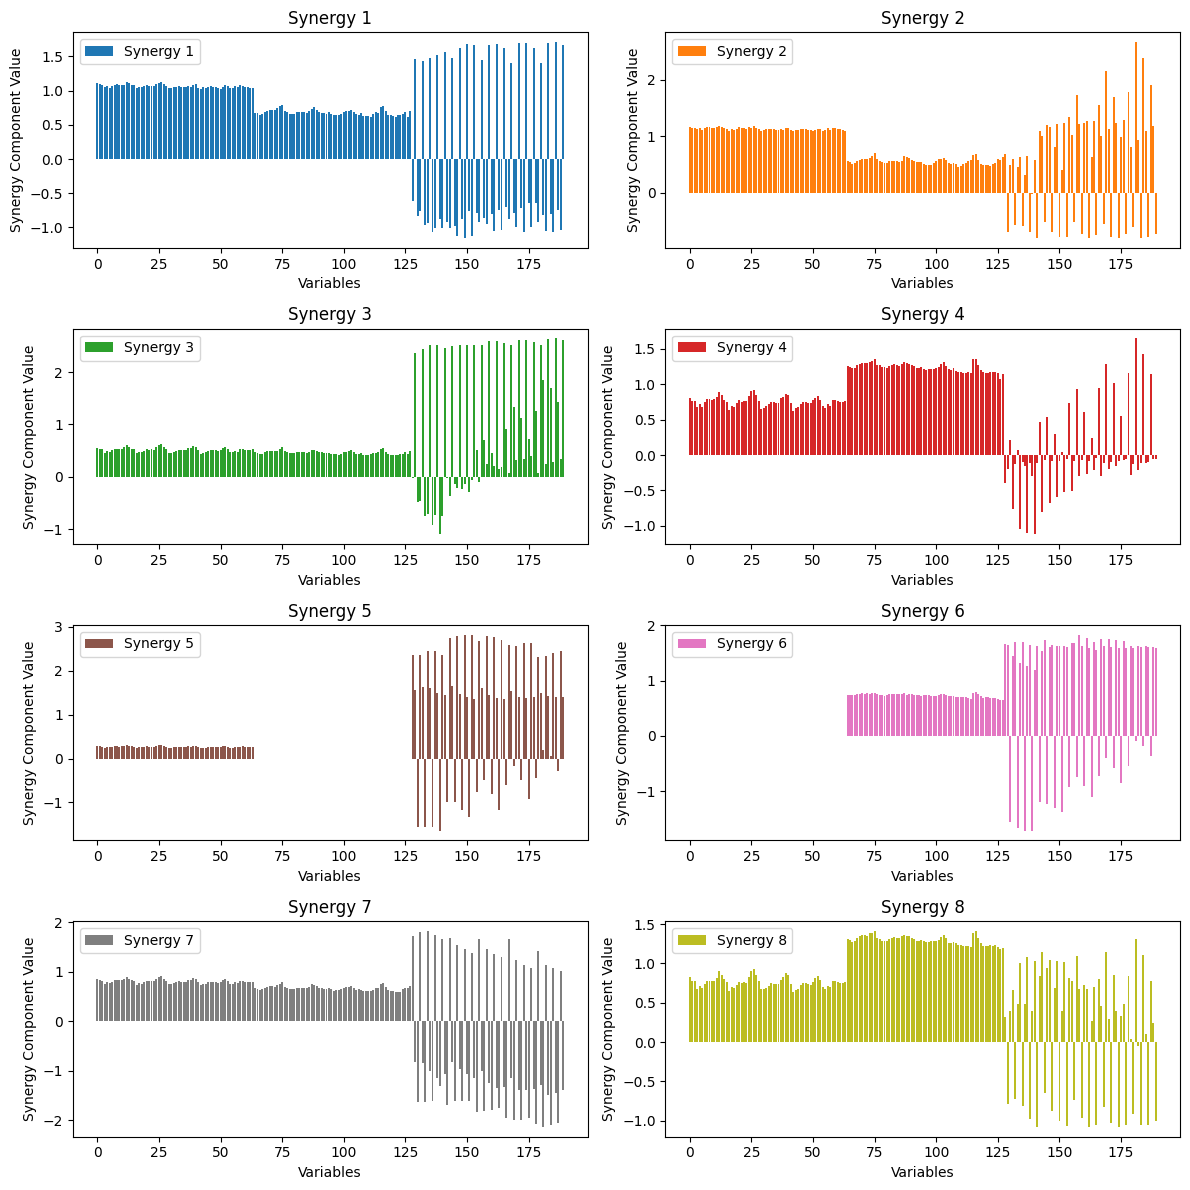

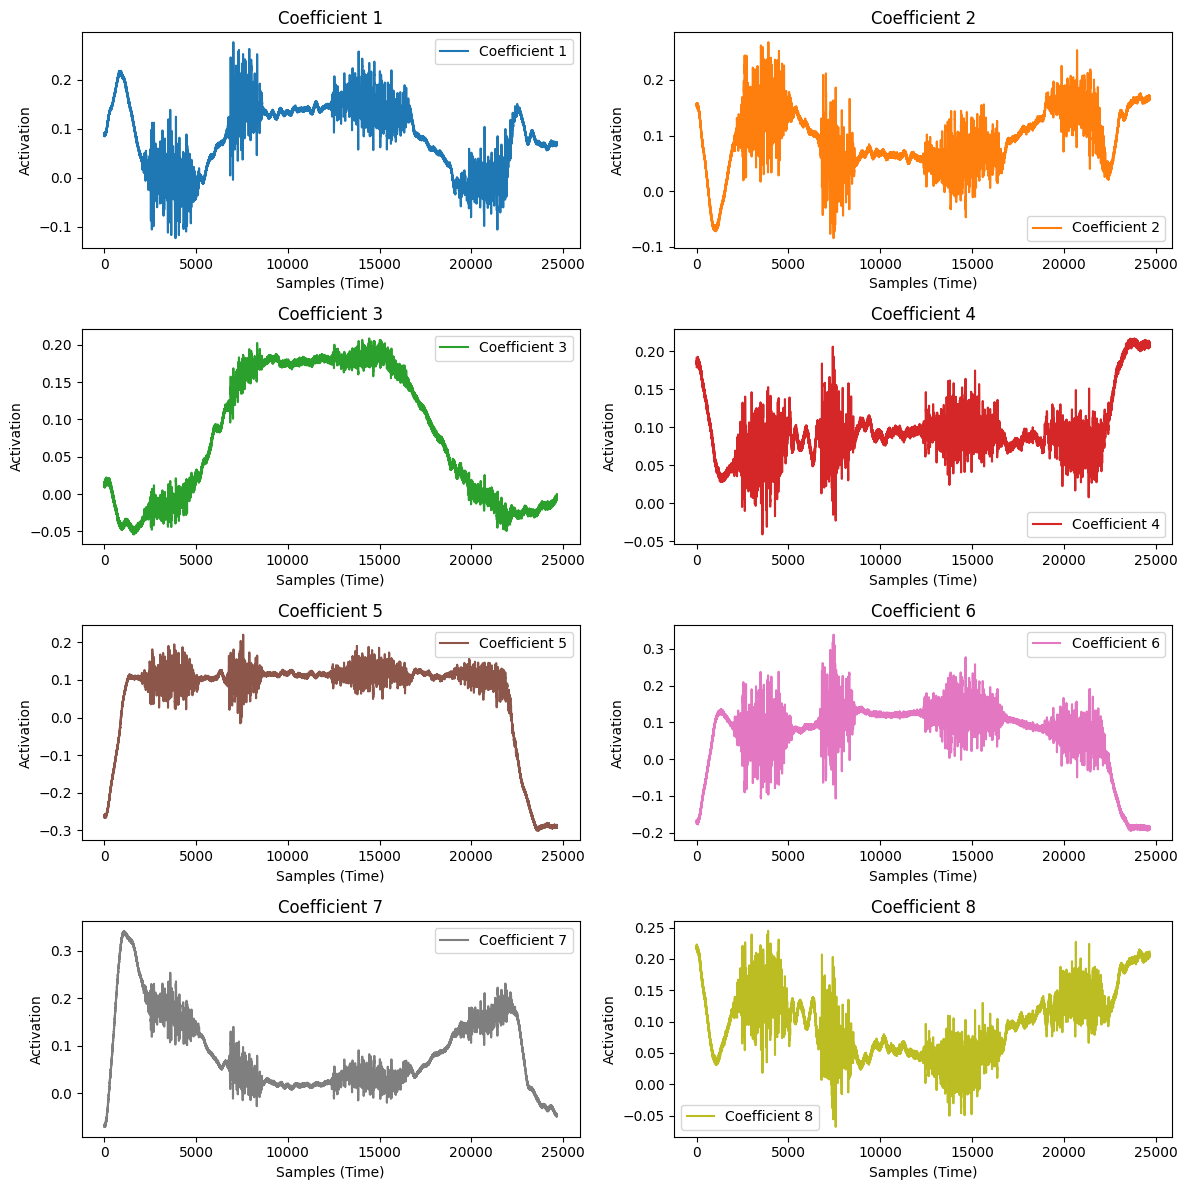

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# Define the MMF algorithm
def initialize_matrices(data, n_synergies):
    np.random.seed(0)  # For reproducibility
    
    # Initialize W and C with small values
    W = np.random.rand(data.shape[0], n_synergies) * 0.01
    C = np.random.rand(n_synergies, data.shape[1]) * 0.01

    # Print the dimensions of W and C
    print(f"Shape of Combined Data Matrix (Variables x Samples): {combined_data.shape}")
    print(f"Shape of W (Variables x Synergies): {W.shape}")
    print(f"Shape of C (Synergies x Samples): {C.shape}")

    return W, C

def update_mmf(X, W, C, mu_W, mu_C, lambd, k):
    # Calculate the gradient updates
    W_update = mu_W * ((X @ C.T) - (W @ (C @ C.T)) - lambd * W)
    C_update = mu_C * ((W.T @ X) - (W.T @ W @ C))

    # Gradient clipping to prevent overflow
    W_update = np.clip(W_update, -0.01, 0.01)
    C_update = np.clip(C_update, -0.01, 0.01)

    # Update matrices
    W += W_update
    C += C_update

    # Enforce non-negativity for EMG components (first 'k' rows)
    W[:k, :] = np.maximum(W[:k, :], 0)  # Only EMG components should be non-negative

    # Let kinematic components (rows after 'k') vary freely (no non-negativity)
    # No need to enforce constraints on W[k:, :] (kinematic part)
    
    return W, C


def mixed_matrix_factorization(X, n_synergies, mu_s, lambd_s, max_iter=1000):
    # Initialize W and C matrices
    W, C = initialize_matrices(X, n_synergies)
    
    # Define number of EMG channels
    k = normalized_emg_signals.shape[1]  # Number of EMG channels
    print(f"Number of EMG Channels = {k}")

    # Total number of variables (EMG + kinematic)
    ndim = X.shape[0]  # Total number of rows of W (EMG + Kinematic)

    # Scaling the parameters
    mu_W = mu_s / np.linalg.norm(X)
    mu_C = mu_s / np.linalg.norm(X)
    
    # Scaled regularization parameter
    lambd = lambd_s / (ndim * n_synergies)

    cost_history = []

    for iteration in range(max_iter):
        W, C = update_mmf(X, W, C, mu_W, mu_C, lambd, k)
        
        # Calculate the cost function value
        cost = 0.5 * np.linalg.norm(X - W @ C) ** 2 + 0.5 * lambd * np.linalg.norm(W, 'fro') ** 2
        cost_history.append(cost)
        
        # Print cost and matrix summaries every 100 iterations
        if iteration % 100 == 0:
            print(f"Iteration {iteration}, Cost: {cost}")
            print(f"W matrix (first few values): {W[:5, 0]}")
            print(f"C matrix (first few values): {C[0, :5]}")

            # Optional: plot first synergy (bar plot) and first coefficient (line plot)
            plt.figure(figsize=(10, 4))

            # Bar plot for the first synergy (W matrix)
            plt.subplot(1, 2, 1)
            plt.bar(np.arange(W.shape[0]), W[:, 0], color='b', label='Synergy 1')
            plt.title('W Matrix First Synergy (Bar Plot)')
            plt.xlabel('Variables')
            plt.ylabel('Synergy Component Value')
            plt.legend()

            # Line plot for the first coefficient (C matrix)
            plt.subplot(1, 2, 2)
            plt.plot(np.arange(C.shape[1]), C[0, :], label='Coefficient 1', color='g')
            plt.title('C Matrix First Coefficient (Line Plot)')
            plt.xlabel('Samples')
            plt.ylabel('Activation')
            plt.legend()

            plt.tight_layout()
            plt.show()

    # Plot cost function history
    plt.figure(figsize=(10, 6))
    plt.plot(cost_history, label='Cost Function')
    plt.title('Cost Function Convergence')
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.legend()
    plt.grid(True)
    plt.show()

    return W, C

# Define number of synergies
n_synergies = 8  # Adjust based on your specific analysis

# Scaled learning rate and regularization parameter
mu_s = 0.1  # Tuning parameter (scaled)
lambd_s = 50  # Tuning parameter for regularization

# Apply MMF algorithm
W, C = mixed_matrix_factorization(combined_data, n_synergies, mu_s, lambd_s)

# Define number of rows for subplots
nrows = int(np.ceil(n_synergies / 2))  # Define rows (2 synergies per row)

# Create subplots for Synergies (W matrix) - Bar Plots
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(12, nrows * 3))

# Flatten the axes array to easily index for each plot
axes = axes.flatten()

# Use the new method to get a colormap
colors = plt.colormaps.get_cmap('tab10')  # Get the 'tab10' colormap

# Plot bar plots for synergies (W matrix)
for i in range(n_synergies):
    axes[i].bar(np.arange(W.shape[0]), W[:, i], color=colors(i / n_synergies), label=f'Synergy {i+1}')
    axes[i].set_title(f'Synergy {i+1}')
    axes[i].set_xlabel('Variables')
    axes[i].set_ylabel('Synergy Component Value')
    axes[i].legend()

# Remove any unused subplots if n_synergies is odd
if n_synergies % 2 != 0:
    fig.delaxes(axes[-1])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Create subplots for Time-varying Coefficients (C matrix) - Line Plots
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(12, nrows * 3))

# Flatten the axes array to easily index for each plot
axes = axes.flatten()

# Plot line plots for time-varying coefficients (C matrix)
for i in range(n_synergies):
    axes[i].plot(np.arange(C.shape[1]), C[i, :], color=colors(i / n_synergies), label=f'Coefficient {i+1}')
    axes[i].set_title(f'Coefficient {i+1}')
    axes[i].set_xlabel('Samples (Time)')
    axes[i].set_ylabel('Activation')
    axes[i].legend()

# Remove any unused subplots if n_synergies is odd
if n_synergies % 2 != 0:
    fig.delaxes(axes[-1])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()



Evaluation of MMF Performance and Reconstruction of the original signal

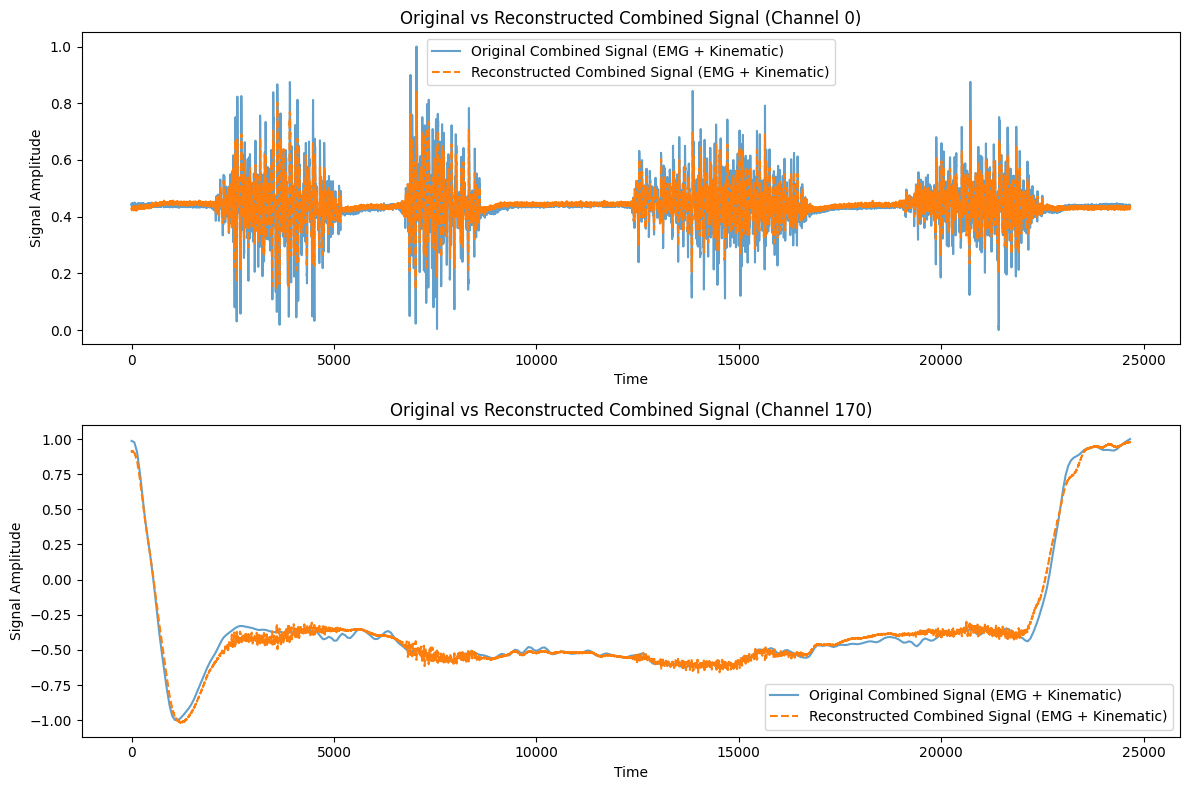

Combined Data Reconstruction R^2: 0.9880


In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Reconstruct the data using the W and C matrices
reconstructed_data = W @ C

# Plot original vs. reconstructed signals for combined data (both EMG and Kinematic signals)
plt.figure(figsize=(12, 8))

# Plot original and reconstructed combined EMG and Kinematic signals for channel 0
plt.subplot(2, 1, 1)
plt.plot(combined_data[5, :], label='Original Combined Signal (EMG + Kinematic)', alpha=0.7)
plt.plot(reconstructed_data[5, :], label='Reconstructed Combined Signal (EMG + Kinematic)', linestyle='--')
plt.title('Original vs Reconstructed Combined Signal (Channel 0)')
plt.xlabel('Time')
plt.ylabel('Signal Amplitude')
plt.legend()

# Plot original and reconstructed combined EMG and Kinematic signals for channel 1
plt.subplot(2, 1, 2)
plt.plot(combined_data[130, :], label='Original Combined Signal (EMG + Kinematic)', alpha=0.7)
plt.plot(reconstructed_data[130, :], label='Reconstructed Combined Signal (EMG + Kinematic)', linestyle='--')
plt.title('Original vs Reconstructed Combined Signal (Channel 170)')
plt.xlabel('Time')
plt.ylabel('Signal Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate R^2 score function
def r2_score(original, reconstructed):
    ss_res = np.sum((original - reconstructed) ** 2)
    ss_tot = np.sum((original - np.mean(original)) ** 2)
    return 1 - (ss_res / ss_tot)

# Calculate R^2 for the combined data
r2_combined = r2_score(combined_data, reconstructed_data)

print(f"Combined Data Reconstruction R^2: {r2_combined:.4f}")
